In [1]:
import joblib
import pandas as pd
import unicodedata
import re
import pickle

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    murs_path = os.path.join(base_dir, f"maquette{i}", f"murs{i}.csv")
    if os.path.exists(murs_path):
        with open(murs_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(murs_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {murs_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {murs_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {murs_path}")

if dfs:
    murs_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {murs_concat.shape[0]} lignes, {murs_concat.shape[1]} colonnes")
else:
    murs_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

murs_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/murs1.csv (1589 lignes, 146 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  779920        GO           MUR          INTERIEUR           POUTRE VOILE   
1  780111        GO           MUR          INTERIEUR           POUTRE VOILE   
2  780661        GO           MUR          INTERIEUR                 BANCHE   
3  783007        GO           MUR          INTERIEUR                 BANCHE   
4  783554        GO           MUR          INTERIEUR           POUTRE VOILE   

           Nom           Hauteur Epaisseur                            AI  \
0  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
1  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
2  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
3  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
4  Voile BA 20  2,88000000000138 

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Hauteur,Epaisseur,AI,AS,...,Resistance_feu,Materiau_type,Classification.UniFormat.II.Number,Classification.UniFormat.II.Description,CVC_Lot,VOILE SOUS TOITURE,Classe Beton,STR_As NGF,STR_NIV_ref,Prefixe
0,779920,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,780111,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,780661,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,783007,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,783554,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
murs_concat.shape

(39042, 351)

In [4]:
print(murs_concat)

            Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation  \
0       779920        GO           MUR          INTERIEUR   
1       780111        GO           MUR          INTERIEUR   
2       780661        GO           MUR          INTERIEUR   
3       783007        GO           MUR          INTERIEUR   
4       783554        GO           MUR          INTERIEUR   
...        ...       ...           ...                ...   
39037  4538519        GO           MUR          INTERIEUR   
39038  4538520        GO           MUR          INTERIEUR   
39039  4545308        GO           MUR          INTERIEUR   
39040  4556093        GO      LONGRINE            COURANT   
39041  4556253        GO      LONGRINE            COURANT   

      014EC_Mode Constructif          Nom           Hauteur Epaisseur  \
0               POUTRE VOILE  Voile BA 20  2,88000000000138       0,2   
1               POUTRE VOILE  Voile BA 20  2,88000000000138       0,2   
2                     BANCHE  Voile BA 20  2,880

In [5]:
print(murs_concat.columns.tolist())

['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation', '014EC_Mode Constructif', 'Nom', 'Hauteur', 'Epaisseur', 'AI', 'AS', 'Sols en intersection', 'Sols coupés (u)', 'Sols coupés (Ids)', 'Sols coupants (u)', 'Sols coupants (Ids)', 'Sol au-dessus', 'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués', 'Mur multicouche', 'Mur empilé', 'Profil modifié', 'Image', 'Catégorie', 'Section', "Type prédéfini d'IFC", 'Exporter au format IFC sous', 'Exporter au format IFC', 'IfcGUID', 'A une association', "Enrobage d'armature - Autres faces", "Enrobage d'armature - Face intérieure", "Enrobage d'armature - Face extérieure", 'Variantes', 'Extension inférieure', 'Extension supérieure', 'Volume', 'Surface', 'Phase de démolition', 'Phase de création', 'Commentaires', 'Longueur', 'Famille et type', 'Famille', 'Type', 'Nom de la famille', 'Nom du type', 'ID du type', 'Lié au volume', 'Structure', 'Identifiant', 'Ligne de justification', 'Utilisation structurelle', 'Partie inférieur

In [6]:
murs_concat

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Hauteur,Epaisseur,AI,AS,...,Resistance_feu,Materiau_type,Classification.UniFormat.II.Number,Classification.UniFormat.II.Description,CVC_Lot,VOILE SOUS TOITURE,Classe Beton,STR_As NGF,STR_NIV_ref,Prefixe
0,779920,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,780111,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,780661,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,783007,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,783554,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39037,4538519,GO,MUR,INTERIEUR,PREMUR,Béton 20,"3,00000000000052","0,2","3,73","6,73000000000052",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39038,4538520,GO,MUR,INTERIEUR,PREMUR,Béton 20,"3,00000000000052","0,2","3,73","6,73000000000052",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39039,4545308,GO,MUR,INTERIEUR,PREMUR,Béton 20,"3,00000000000052","0,2","3,73","6,73000000000052",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39040,4556093,GO,LONGRINE,COURANT,COFFRE,Béton 25,"2,01","0,25","-2,01000000000202","-0,00000000000201656931153593",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type",
    "Nom",
]


In [8]:
murs_concat = murs_concat[[col for col in colonnes_a_garder if col in murs_concat.columns]]

In [9]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

murs_concat.columns = [clean_col(c) for c in murs_concat.columns]
print(murs_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'fenetres', 'portes', 'ouvertures', 'murs_imbriques', 'mur_multicouche', 'profil_modifie', 'extension_inferieure', 'extension_superieure', 'partie_inferieure_attachee', 'partie_superieure_attachee', 'decalage_superieur', 'decalage_inferieur', 'materiau_structurel', 'famille_et_type', 'nom']


In [10]:
murs_concat

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif,epaisseur,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,...,profil_modifie,extension_inferieure,extension_superieure,partie_inferieure_attachee,partie_superieure_attachee,decalage_superieur,decalage_inferieur,materiau_structurel,famille_et_type,nom
0,GO,MUR,INTERIEUR,POUTRE VOILE,"0,2",0,0,3,True,True,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
1,GO,MUR,INTERIEUR,POUTRE VOILE,"0,2",0,0,1,False,True,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
2,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,3,True,True,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
3,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,3,True,True,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
4,GO,MUR,INTERIEUR,POUTRE VOILE,"0,2",0,0,3,False,True,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39037,GO,MUR,INTERIEUR,PREMUR,"0,2",0,0,0,False,False,...,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20,Béton 20
39038,GO,MUR,INTERIEUR,PREMUR,"0,2",0,0,0,True,False,...,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20,Béton 20
39039,GO,MUR,INTERIEUR,PREMUR,"0,2",0,0,0,True,False,...,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20,Béton 20
39040,GO,LONGRINE,COURANT,COFFRE,"0,25",2,0,0,True,False,...,False,0,0,0,0,0,"-2,01",BÉTON,Mur de base: Béton 25,Béton 25


In [11]:
# Définir les targets multi-label (adapte la liste selon tes besoins)
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Nettoyer les noms de colonnes et les rendre uniques
def make_unique(cols):
    seen = {}
    new_cols = []
    for col in cols:
        if col not in seen:
            seen[col] = 0
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
    return new_cols

murs_concat.columns = make_unique([clean_col(c) for c in murs_concat.columns])
print(murs_concat.columns.tolist())

# Déterminer les colonnes cibles effectivement présentes dans le DataFrame
targets_in_df = [col for col in targets if col in murs_concat.columns]


if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans murs_concat. Colonnes disponibles : {murs_concat.columns.tolist()}")

# X et y_multi (après avoir rendu les colonnes uniques)
X = murs_concat.drop(columns=targets_in_df)
y_multi = murs_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'fenetres', 'portes', 'ouvertures', 'murs_imbriques', 'mur_multicouche', 'profil_modifie', 'extension_inferieure', 'extension_superieure', 'partie_inferieure_attachee', 'partie_superieure_attachee', 'decalage_superieur', 'decalage_inferieur', 'materiau_structurel', 'famille_et_type', 'nom']


In [12]:
X


,epaisseur,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,fenetres,portes,ouvertures,murs_imbriques,...,profil_modifie,extension_inferieure,extension_superieure,partie_inferieure_attachee,partie_superieure_attachee,decalage_superieur,decalage_inferieur,materiau_structurel,famille_et_type,nom
0,"0,2",0,0,3,True,True,0,0,0,0,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
1,"0,2",0,0,1,False,True,0,0,0,0,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
2,"0,2",0,0,3,True,True,0,1,0,0,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
3,"0,2",0,0,3,True,True,0,1,0,0,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
4,"0,2",0,0,3,False,True,0,0,0,0,...,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20,Voile BA 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39037,"0,2",0,0,0,False,False,0,0,0,0,...,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20,Béton 20
39038,"0,2",0,0,0,True,False,0,0,0,0,...,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20,Béton 20
39039,"0,2",0,0,0,True,False,0,0,0,0,...,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20,Béton 20
39040,"0,25",2,0,0,True,False,0,0,0,0,...,False,0,0,0,0,0,"-2,01",BÉTON,Mur de base: Béton 25,Béton 25


In [13]:
targets

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']

In [16]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type",
    "Nom",
]

# On ne garde que les colonnes présentes dans le DataFrame
#df_test = df_test[[col for col in colonnes_a_garder if col in df_test.columns]]

In [17]:
# Convertir toutes les colonnes catégorielles en string pour éviter les erreurs d'encodage
for col in cat_features:
    if col in X.columns:
        X[col] = X[col].astype(str)

# Supprimer les colonnes numériques entièrement vides
num_features = [col for col in num_features if not X[col].isnull().all()]
X = X[num_features + cat_features]

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(RandomForestClassifier(n_estimators=500, random_state=42)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]

# Entraînement
pipeline.fit(X_train, y_train)

# Prédiction et score baseline
joblib.dump(pipeline, 'randomforestmurspipeline.pkl')

print("Pipeline complet sauvegardé dans bimpredict_pipeline.pkl")

Pipeline complet sauvegardé dans bimpredict_pipeline.pkl


In [18]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sols_en_intersection',
                                                   'sols_coupes_u',
                                                   'sols_coupants_u',
                                                   'fenetres', 'portes',
                                                   'ouvertures',
                                                   'murs_imbriques',
                                                   'extension_inferieure',
                                                   'extension_superieure',
                                                   'partie_inferieure_attachee',
                                                   'partie_superieure_attachee']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['epaisseur',
                                                   'decalage_superieur',
                                                   'decalage_inferieur',
                                                   'materiau_structurel',
                                                   'famille_et_type',
                                                   'nom'])])),
                ('model',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=500,
                                                                        random_state=42)))])

In [ ]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 7117 échantillons.


In [ ]:
y_multi

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,MUR,INTERIEUR,POUTRE VOILE
1,GO,MUR,INTERIEUR,POUTRE VOILE
2,GO,MUR,INTERIEUR,BANCHE
3,GO,MUR,INTERIEUR,BANCHE
4,GO,MUR,INTERIEUR,POUTRE VOILE
...,...,...,...,...
39037,GO,MUR,INTERIEUR,PREMUR
39038,GO,MUR,INTERIEUR,PREMUR
39039,GO,MUR,INTERIEUR,PREMUR
39040,GO,LONGRINE,COURANT,COFFRE


In [ ]:
from sklearn.metrics import f1_score

# Générer les prédictions sur le jeu de test
y_pred = pipeline.predict(X_test)

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['str_ep' 'str_ht' 'voile_sous_toiture']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


F1 micro (moyenne par cible): 0.9768
F1 macro (moyenne par cible): 0.8966


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
2      013ec_localisation  0.794791
3  014ec_mode_constructif  0.845301
1           012ec_ouvrage  0.946479
0               011ec_lot  1.000000


Attention: feature_names (95840) et importances (95837) n'ont pas la même longueur. Troncature à 95837.
                                                 Feature  Importance
0                                                     id    0.020065
21458  enrobage_darmature_face_interieure_Enrobage d'...    0.018427
21464  enrobage_darmature_face_exterieure_Enrobage d'...    0.017687
21452  enrobage_darmature_autres_faces_Enrobage d'arm...    0.015265
16                                             structure    0.014647
18                              utilisation_structurelle    0.013907
14                                            id_du_type    0.012051
95519            resistance_thermique_r_1,44359464627151    0.010559
40                                              fonction    0.010308
95483          resistance_thermique_r_0,0782608695652174    0.009486
95474                              masse_thermique_91140    0.009463
95528  coefficient_de_transfert_thermique_u_1,1886363...    0.009458

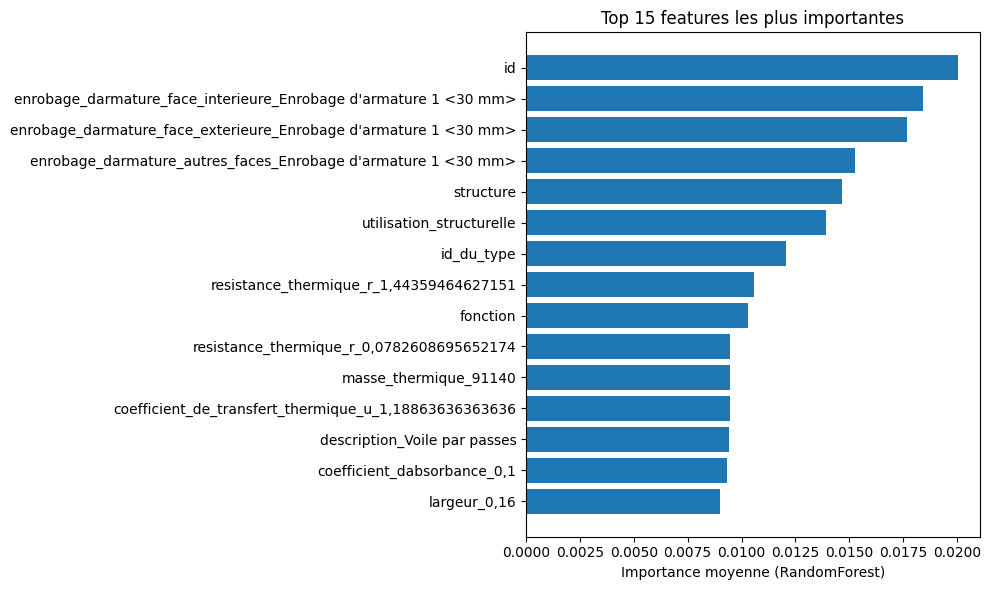

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer le modèle entraîné
rf_multi = pipeline.named_steps['model']

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

# Calculer l'importance moyenne des features sur toutes les cibles
importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

# S'assurer que feature_names et importances ont la même longueur
if len(feature_names) != len(importances):
    min_len = min(len(feature_names), len(importances))
    print(f"Attention: feature_names ({len(feature_names)}) et importances ({len(importances)}) n'ont pas la même longueur. Troncature à {min_len}.")
    feature_names = feature_names[:min_len]
    importances = importances[:min_len]

# DataFrame pour affichage
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Afficher les 15 features les plus importantes
print(feat_imp.head(15))

# Visualisation
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel("Importance moyenne (RandomForest)")
plt.title("Top 15 features les plus importantes")
plt.tight_layout()
plt.show()

In [ ]:
y_pred[:, 0]

array(['GO', 'GO', 'GO', ..., 'PLATRERIE', 'FACADE', 'FACADE'],
      dtype=object)

In [ ]:
y_test.iloc[:, 0]

21088           GO
21668           GO
36940           GO
14422           GO
34082    PLATRERIE
           ...    
24890    PLATRERIE
13308       FACADE
3456     PLATRERIE
33601       FACADE
13729       FACADE
Name: 011ec_lot, Length: 7117, dtype: object

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer le modèle entraîné
rf_multi = pipeline.named_steps['model']

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

# Calculer l'importance moyenne des features sur toutes les cibles
importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

# DataFrame pour affichage
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

import seaborn as sns

# Afficher la distribution de chaque cible sur y_test
for col in y_test.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=y_test[col], order=y_test[col].value_counts().index)
    plt.title(f"Distribution de la cible : {col} (jeu de test)")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

ValueError: All arrays must be of the same length

In [ ]:
from sklearn.metrics import classification_report

# Classification report pour chaque cible séparément
for i, col in enumerate(y_test.columns):
	print(f"=== Classification Report for {col} ===")
	print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

=== Classification Report for 011ec_lot ===
              precision    recall  f1-score   support

  COUVERTURE       1.00      1.00      1.00        21
    EXISTANT       1.00      1.00      1.00         3
      FACADE       1.00      1.00      1.00       175
          GO       1.00      1.00      1.00      5630
         OUT       1.00      1.00      1.00         4
   PLATRERIE       1.00      1.00      1.00      1281
  SERRURERIE       1.00      1.00      1.00         3

    accuracy                           1.00      7117
   macro avg       1.00      1.00      1.00      7117
weighted avg       1.00      1.00      1.00      7117

=== Classification Report for 012ec_ouvrage ===
                      precision    recall  f1-score   support

            ACROTERE       1.00      0.96      0.98       131
              ALLEGE       1.00      1.00      1.00         7
  AMENAGEMENT BASSIN       1.00      1.00      1.00         1
               BECHE       1.00      0.75      0.86         4


/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

In [ ]:
y_pred_df['011ec_lot'].value_counts()


GO            5630
PLATRERIE     1281
FACADE         175
COUVERTURE      21
OUT              4
EXISTANT         3
SERRURERIE       3
Name: 011ec_lot, dtype: int64

In [19]:
# Charger le CSV
csv_path = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/datatest/test-3/test3/targettest3/murs-3.csv"
if not os.path.isfile(csv_path):
    print(f"Le fichier n'existe pas : {csv_path}")
    df_test = None
else:
    df_test = pd.read_csv(csv_path, delimiter=';', header=1)

In [21]:
df_test.shape

(259, 102)

In [ ]:
df_test.columns

Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Nom', 'Hauteur', 'Epaisseur', 'AI', 'AS',
       'Sols en intersection', 'Sols coupés (u)', 'Sols coupés (Ids)',
       'Sols coupants (u)', 'Sols coupants (Ids)', 'Sol au-dessus',
       'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués',
       'Mur multicouche', 'Mur empilé', 'Profil modifié', 'Image', 'Catégorie',
       'Section', 'Type prédéfini d'IFC', 'Exporter au format IFC sous',
       'Exporter au format IFC', 'IfcGUID', 'A une association',
       'Enrobage d'armature - Autres faces',
       'Enrobage d'armature - Face intérieure',
       'Enrobage d'armature - Face extérieure', 'Variantes',
       'Extension inférieure', 'Extension supérieure', 'Volume', 'Surface',
       'Phase de démolition', 'Phase de création', 'Commentaires', 'Longueur',
       'Famille et type', 'Famille', 'Type', 'Nom de la famille',
       'Nom du type', 'ID du type', 'Lié au volu

In [ ]:
df_test['013EC_Localisation'].value_counts()

INTERIEUR        133
EXTERIEUR        113
CAGE ESCALIER     13
Name: 013EC_Localisation, dtype: int64

In [ ]:
df_test

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Hauteur,Epaisseur,AI,AS,...,Code d'assemblage,Retournement aux insertions,Retournement aux extrémités,Couleur vue détail faible,Motif vue détail faible,Marque de type,Protection contre l'incendie,Coût,Fonction,Largeur
0,1673112,GO,MUR,EXTERIEUR,BERLIMUR,TPFI-BETON ARME-Voile S.sol-25,"0,88","0,25","-4,12999999999982","-3,24999999999982",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,25"
1,1673116,GO,MUR,EXTERIEUR,BERLIMUR,TPFI-BETON ARME-Voile S.sol-25,"0,880000000000005","0,25","-4,12999999999982","-3,24999999999982",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,25"
2,1673118,GO,MUR,INTERIEUR,BANCHE,TPFI-BETON ARME-Voile S.sol-20,"0,880000000000005","0,2","-4,12999999999982","-3,24999999999982",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,2"
3,1673124,GO,MUR,INTERIEUR,BANCHE,TPFI-BETON ARME-Voile S.sol-20,"1,08","0,2","-4,32999999999982","-3,24999999999982",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,2"
4,1673132,GO,MUR,INTERIEUR,BANCHE,TPFI-BETON ARME-Voile S.sol-25,"0,88","0,25","-4,12999999999982","-3,24999999999982",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,25"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,1699448,GO,MUR,EXTERIEUR,FOB,TPFI-FOB-34,"3,23","0,34","7,55000000000081","10,7800000000008",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,34"
1073,1699589,GO,MUR,EXTERIEUR,FOB,TPFI-FOB-34,"2,34000000000014","0,34","16,5799999999999","18,9200000000001",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,34"
1074,1699643,GO,MUR,EXTERIEUR,FOB,TPFI-FOB-34,"2,57000000000072","0,34","11,0000000000001","13,5700000000008",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,34"
1075,1700169,GO,MUR,EXTERIEUR,BANCHE,TPFI-BETON ARME-Voile S.sol-25,"4,05999999999984","0,25","-4,12999999999982","-0,0699999999999841",...,NaN,0,0,0,NaN,NaN,NaN,0,1,"0,25"


In [ ]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type",
    "Nom",
]

# On ne garde que les colonnes présentes dans le DataFrame
df_test = df_test[[col for col in colonnes_a_garder if col in df_test.columns]]

In [ ]:
df_test

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif,epaisseur,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,...,profil_modifie,extension_inferieure,extension_superieure,partie_inferieure_attachee,partie_superieure_attachee,decalage_superieur,decalage_inferieur,materiau_structurel,famille_et_type,nom
0,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
1,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
2,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
3,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
4,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,0,True,True,...,False,0,0,0,1,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
255,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
256,GO,MUR,EXTERIEUR,PREMUR,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
257,GO,MUR,CAGE ESCALIER,BANCHE,"0,2",1,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.


In [ ]:
def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

df_test.columns = [clean_col(c) for c in df_test.columns]
print(df_test.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'fenetres', 'portes', 'ouvertures', 'murs_imbriques', 'mur_multicouche', 'profil_modifie', 'extension_inferieure', 'extension_superieure', 'partie_inferieure_attachee', 'partie_superieure_attachee', 'decalage_superieur', 'decalage_inferieur', 'materiau_structurel', 'famille_et_type', 'nom']


In [ ]:
df_test.head()

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif,epaisseur,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,...,profil_modifie,extension_inferieure,extension_superieure,partie_inferieure_attachee,partie_superieure_attachee,decalage_superieur,decalage_inferieur,materiau_structurel,famille_et_type,nom
0,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
1,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
2,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
3,GO,MUR,EXTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.
4,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,0,True,True,...,False,0,0,0,1,0,0,EIF_STR - Béton,Mur de base: EC-BA ép. 20 EXT.,EC-BA ép. 20 EXT.


In [ ]:
targets_test = df_test.columns[:4]

In [ ]:
df_test.dropna(subset=targets_test, how='all', inplace=True)

/var/folders/x6/j7yc7yjj3xd1bjpj4469g9880000gn/T/ipykernel_84696/2316456771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(subset=targets_test, how='all', inplace=True)


In [ ]:
targets_test

Index(['011ec_lot', '012ec_ouvrage', '013ec_localisation',
       '014ec_mode_constructif'],
      dtype='object')

In [ ]:
df_test.isna().sum()

011ec_lot                     0
012ec_ouvrage                 0
013ec_localisation            0
014ec_mode_constructif        0
epaisseur                     0
sols_en_intersection          0
sols_coupes_u                 0
sols_coupants_u               0
sol_au_dessus                 0
sol_en_dessous                0
fenetres                      0
portes                        0
ouvertures                    0
murs_imbriques                0
mur_multicouche               0
profil_modifie                0
extension_inferieure          0
extension_superieure          0
partie_inferieure_attachee    0
partie_superieure_attachee    0
decalage_superieur            0
decalage_inferieur            0
materiau_structurel           0
famille_et_type               0
nom                           0
dtype: int64

In [ ]:
X_test_new = df_test.drop(columns=targets_test)

In [ ]:
targets_test

Index(['011ec_lot', '012ec_ouvrage', '013ec_localisation',
       '014ec_mode_constructif'],
      dtype='object')

In [ ]:
y_test_new = df_test[targets_test]

In [ ]:
df_test

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif,epaisseur,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,...,profil_modifie,extension_inferieure,extension_superieure,partie_inferieure_attachee,partie_superieure_attachee,decalage_superieur,decalage_inferieur,materiau_structurel,famille_et_type,nom
0,GO,MUR,EXTERIEUR,BERLIMUR,"0,25",0,0,0,False,False,...,False,0,0,0,1,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25
1,GO,MUR,EXTERIEUR,BERLIMUR,"0,25",1,0,1,False,False,...,False,0,0,0,0,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25
2,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,0,False,False,...,False,0,0,0,0,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-20,TPFI-BETON ARME-Voile S.sol-20
3,GO,MUR,INTERIEUR,BANCHE,"0,2",1,0,1,True,False,...,False,0,0,0,0,"-0,02","-1,1",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-20,TPFI-BETON ARME-Voile S.sol-20
4,GO,MUR,INTERIEUR,BANCHE,"0,25",0,0,0,True,False,...,False,0,0,0,1,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,GO,MUR,EXTERIEUR,FOB,"0,34",0,0,0,True,True,...,False,0,0,0,0,"-0,22",0,TPFI_BOIS,Mur de base: TPFI-FOB-34,TPFI-FOB-34
1073,GO,MUR,EXTERIEUR,FOB,"0,34",0,0,0,False,True,...,False,0,0,0,0,"-0,45","0,02",TPFI_BOIS,Mur de base: TPFI-FOB-34,TPFI-FOB-34
1074,GO,MUR,EXTERIEUR,FOB,"0,34",0,0,0,True,True,...,False,0,0,0,0,"-0,219999999999238",0,TPFI_BOIS,Mur de base: TPFI-FOB-34,TPFI-FOB-34
1075,GO,MUR,EXTERIEUR,BANCHE,"0,25",1,0,0,False,False,...,False,0,0,0,0,"-0,210000000000007","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25


In [ ]:
y_pred = pipeline.predict(X_test_new)

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

In [ ]:
y_pred_df['011ec_lot']

0      GO
1      GO
2      GO
3      GO
4      GO
       ..
254    GO
255    GO
256    GO
257    GO
258    GO
Name: 011ec_lot, Length: 259, dtype: object

In [ ]:
y_test_new

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,MUR,EXTERIEUR,BERLIMUR
1,GO,MUR,EXTERIEUR,BERLIMUR
2,GO,MUR,INTERIEUR,BANCHE
3,GO,MUR,INTERIEUR,BANCHE
4,GO,MUR,INTERIEUR,BANCHE
...,...,...,...,...
1072,GO,MUR,EXTERIEUR,FOB
1073,GO,MUR,EXTERIEUR,FOB
1074,GO,MUR,EXTERIEUR,FOB
1075,GO,MUR,EXTERIEUR,BANCHE


In [ ]:
print(y_test_new['011ec_lot'].value_counts())
print(y_pred_df['011ec_lot'].value_counts())

GO    1026
Name: 011ec_lot, dtype: int64
GO        702
FACADE    324
Name: 011ec_lot, dtype: int64


In [ ]:
y_pred_df['011ec_lot'] = y_pred_df['011ec_lot'].astype(str)
y_test_new['011ec_lot'] = y_test_new['011ec_lot'].astype(str)

/var/folders/x6/j7yc7yjj3xd1bjpj4469g9880000gn/T/ipykernel_84696/1072579041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_new['011ec_lot'] = y_test_new['011ec_lot'].astype(str)


In [ ]:
y_pred_df

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,MUR,EXTERIEUR,BANCHE
1,GO,MUR,INTERIEUR,BANCHE
2,GO,MUR,EXTERIEUR,BANCHE
3,GO,MUR,INTERIEUR,BANCHE
4,GO,MUR,INTERIEUR,BANCHE
...,...,...,...,...
254,GO,MUR,EXTERIEUR,BANCHE
255,GO,MUR,EXTERIEUR,BANCHE
256,GO,MUR,EXTERIEUR,BANCHE
257,GO,MUR,INTERIEUR,BANCHE


In [ ]:
y_test_new

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,MUR,EXTERIEUR,BANCHE
1,GO,MUR,INTERIEUR,BANCHE
2,GO,MUR,EXTERIEUR,BANCHE
3,GO,MUR,EXTERIEUR,BANCHE
4,GO,MUR,INTERIEUR,BANCHE
...,...,...,...,...
254,GO,MUR,EXTERIEUR,BANCHE
255,GO,MUR,EXTERIEUR,BANCHE
256,GO,MUR,EXTERIEUR,PREMUR
257,GO,MUR,CAGE ESCALIER,BANCHE


In [ ]:
print(y_test_new['014ec_mode_constructif'].value_counts())
y_pred_df['014ec_mode_constructif'].value_counts()

BANCHE         182
PREMUR          76
PREFA USINE      1
Name: 014ec_mode_constructif, dtype: int64


BANCHE    259
Name: 014ec_mode_constructif, dtype: int64

In [ ]:
print(classification_report(y_test_new['013ec_localisation'], y_pred_df['013ec_localisation']))

               precision    recall  f1-score   support

CAGE ESCALIER       0.00      0.00      0.00        13
    EXTERIEUR       0.81      0.23      0.36       113
    INTERIEUR       0.56      0.95      0.71       133

     accuracy                           0.59       259
    macro avg       0.46      0.39      0.35       259
 weighted avg       0.64      0.59      0.52       259



/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

In [ ]:
from sklearn.metrics import classification_report

# Classification report pour chaque cible séparément
for i, col in enumerate(y_test_new.columns):
	print(f"=== Classification Report for {col} ===")
	print(classification_report(y_test_new.iloc[:, i], y_pred[:, i]))

=== Classification Report for 011ec_lot ===


TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:
X_test_new.columns

Index(['id', '014ec_mode_constructif', 'nom', 'hauteur', 'epaisseur', 'ai',
       'as', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupes_ids',
       'sols_coupants_u', 'sols_coupants_ids', 'sol_au_dessus',
       'sol_en_dessous', 'fenetres', 'portes', 'ouvertures', 'murs_imbriques',
       'mur_multicouche', 'mur_empile', 'profil_modifie', 'image', 'categorie',
       'section', 'type_predefini_difc', 'exporter_au_format_ifc_sous',
       'exporter_au_format_ifc', 'ifcguid', 'a_une_association',
       'enrobage_darmature_autres_faces', 'enrobage_darmature_face_interieure',
       'enrobage_darmature_face_exterieure', 'variantes',
       'extension_inferieure', 'extension_superieure', 'volume', 'surface',
       'phase_de_demolition', 'phase_de_creation', 'commentaires', 'longueur',
       'famille_et_type', 'famille', 'type', 'nom_de_la_famille',
       'nom_du_type', 'id_du_type', 'lie_au_volume', 'structure',
       'identifiant', 'ligne_de_justification', 'utilisation_struc

In [ ]:
X_test_new

,011ec_lot,epaisseur,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,fenetres,portes,ouvertures,...,profil_modifie,extension_inferieure,extension_superieure,partie_inferieure_attachee,partie_superieure_attachee,decalage_superieur,decalage_inferieur,materiau_structurel,famille_et_type,nom
0,GO,"0,25",0,0,0,False,False,0,0,0,...,False,0,0,0,1,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25
1,GO,"0,25",1,0,1,False,False,0,0,0,...,False,0,0,0,0,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25
2,GO,"0,2",0,0,0,False,False,0,0,0,...,False,0,0,0,0,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-20,TPFI-BETON ARME-Voile S.sol-20
3,GO,"0,2",1,0,1,True,False,0,0,0,...,False,0,0,0,0,"-0,02","-1,1",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-20,TPFI-BETON ARME-Voile S.sol-20
4,GO,"0,25",0,0,0,True,False,0,0,0,...,False,0,0,0,1,"-0,02","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,GO,"0,34",0,0,0,True,True,2,0,0,...,False,0,0,0,0,"-0,22",0,TPFI_BOIS,Mur de base: TPFI-FOB-34,TPFI-FOB-34
1073,GO,"0,34",0,0,0,False,True,0,2,0,...,False,0,0,0,0,"-0,45","0,02",TPFI_BOIS,Mur de base: TPFI-FOB-34,TPFI-FOB-34
1074,GO,"0,34",0,0,0,True,True,2,0,0,...,False,0,0,0,0,"-0,219999999999238",0,TPFI_BOIS,Mur de base: TPFI-FOB-34,TPFI-FOB-34
1075,GO,"0,25",1,0,0,False,False,0,0,0,...,False,0,0,0,0,"-0,210000000000007","-0,9",TPFI_BA,Mur de base: TPFI-BETON ARME-Voile S.sol-25,TPFI-BETON ARME-Voile S.sol-25
